# Wingbeat analysis
This notebook demonstrates how to analyse wingbeat data output from camfi.

First, load the required libraries.

In [1]:
from math import sqrt
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from camfi.projectconfig import CamfiConfig
from camfi.plotting.matplotlib import MatplotlibWingbeatFrequencyPlotter
from camfi.wingbeat import BcesEM, GMM, WeightedGaussian

To run `via_project.load_all_exif_metadata` and `wingbeat_extractor.extract_wingbeats()` below, you will first need to download the dataset `2019-11_cabramurra.zip` from the Zenodo repository. The link to the repository is here: https://doi.org/10.5281/zenodo.4950570.

If you uncomment the code in the next three code cells, it is assumed you have extracted the images to `"data/"`. Of course you can extract it elsewhere and change `root` config variable accordingly.

`"data/cabramurra_all_annotations.json"` already contains all the wingbeat data we need, so in this instance, we don't need to re-run the time-consuming metadata and wingbeat extraction code. Therefore, we don't need the image files.

The next cell loads the annotations, and the location and time data used to correct the camera timestamps, which can often be out (either if the camera was set incorrectly, or if it just has an inaccurate clock... which is often the case for cheap cameras).

In [2]:
config_path = "data/cabramurra_config.yml"

config = CamfiConfig.parse_yaml_file(config_path)

# We can print out our config using config.json() or config.yaml()
print(config.json(exclude_unset=True, indent=2))

{
  "root": "data",
  "via_project_file": "data/cabramurra_all_annotations.json",
  "day_zero": "2019-01-01",
  "output_tz": "+10:00",
  "filters": {
    "image_filters": {
      "min_annotations": 1
    }
  },
  "camera": {
    "camera_time_to_actual_time_ratio": 1.0,
    "line_rate": 90500.0
  },
  "time": {
    "camera_placements": {
      "2019-11_cabramurra/0004": {
        "camera_start_time": "2019-10-14T13:00:00+11:00",
        "actual_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      }
    }
  },
  "place": {
    "locations": [
      {
        "name": "cabramurra",
        "lat": -35.9507,
        "lon": 148.3972,
        "elevation_m": 1513.9,
        "tz": "+10:00"
      }
    ],
    "weather_stations": [
      {
        "location": {
          "name": "cabramurra_smhea_aws_072161",
          "lat": -35.94,
         

To get the timestamps for the images, we need to read the EXIF metadata from the image files. Here we also apply time correction. The code is commented out since the metadata has already been loaded into `"data/cabramurra_all_annotations.json"`, but if you are working with a different dataset, or would like to re-run IO intensive this step, uncomment the code.

In [3]:
# Uncomment if exif metadata hasn't been loaded already.
# config.load_all_exif_metadata()

After the EXIF metadata has been loaded, we can run the camfi algorithm to measure the wingbeat frequencies of moths seen in the images. Again, this has already been run and the data is included in `"data/cabramurra_all_annotations.json"`, so only uncomment if you have downloaded the image dataset and want to re-run (or you are running on your own dataset). This step may take a while to run.

**Note:** This step can be accelerated using a GPU. If you have one on your system, consider setting `"wingbeat_extraction":{"device":"cuda","backup_device":"cpu"}` in `data/cabramurra_config.json`.

In [4]:
# Uncomment if wingbeat data hasn't been extracted already
# config.extract_all_wingbeats()

After running the above two steps, you might like to save the results to a new VIA project file. Uncommenting the following will save a new VIA project file to `"data/all_annotations_with_wingbeats.json"`.

In [5]:
# with open("data/all_annotations_with_wingbeats.json", "w") as f:
#     f.write(config.via_project.json(indent=2, exclude_unset=True))

The `camfi.datamodel.via.ViaProject` class is useful for loading and validating files which are compatible with VIA, however for some analyses it is more convenient to have a Pandas DataFrame. The `to_region_dataframe` method of `camfi.datamodel.via.ViaProject` makes this conversion simple.

In [6]:
regions = config.via_project.to_region_dataframe()
regions

,img_key,filename,name,datetime_corrected,datetime_original,exposure_time,location,pixel_x_dimension,pixel_y_dimension,score,best_peak,blur_length,snr,wb_freq_up,wb_freq_down,et_up,et_dn
0,2019-11_cabramurra/0001/DSCF0009.JPG-1,2019-11_cabramurra/0001/DSCF0009.JPG,polyline,2019-11-14 20:20:26+11:00,2019-11-14 20:20:26,0.111111,cabramurra,4608,3456,None,111.0,536.292725,12.966407,44.505436,41.726944,0.107531,0.114691
1,2019-11_cabramurra/0001/DSCF0010.JPG-1,2019-11_cabramurra/0001/DSCF0010.JPG,polyline,2019-11-14 20:30:29+11:00,2019-11-14 20:30:29,0.111111,cabramurra,4608,3456,None,237.0,1008.291016,5.783094,40.686996,35.853527,0.104095,0.118128
2,2019-11_cabramurra/0001/DSCF0010.JPG-1,2019-11_cabramurra/0001/DSCF0010.JPG,polyline,2019-11-14 20:30:29+11:00,2019-11-14 20:30:29,0.111111,cabramurra,4608,3456,None,165.0,675.603577,21.689453,36.698574,36.494766,0.110802,0.111421
3,2019-11_cabramurra/0001/DSCF0010.JPG-1,2019-11_cabramurra/0001/DSCF0010.JPG,polyline,2019-11-14 20:30:29+11:00,2019-11-14 20:30:29,0.111111,cabramurra,4608,3456,None,116.0,660.467407,6.046125,51.069618,50.624634,0.110625,0.111597
4,2019-11_cabramurra/0001/DSCF0010.JPG-1,2019-11_cabramurra/0001/DSCF0010.JPG,circle,2019-11-14 20:30:29+11:00,2019-11-14 20:30:29,0.111111,cabramurra,4608,3456,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,2019-11_cabramurra/0010/DSCF0747.JPG-1,2019-11_cabramurra/0010/DSCF0747.JPG,point,2019-11-24 23:21:23+11:00,2019-11-24 23:21:23,0.100000,cabramurra,4608,3456,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1415,2019-11_cabramurra/0010/DSCF0777.JPG-1,2019-11_cabramurra/0010/DSCF0777.JPG,polyline,2019-11-25 04:22:54+11:00,2019-11-25 04:22:54,0.100000,cabramurra,4608,3456,None,107.0,520.138428,11.467738,48.212074,48.084389,0.099867,0.100133
1416,2019-11_cabramurra/0010/DSCF0779.JPG-1,2019-11_cabramurra/0010/DSCF0779.JPG,polyline,2019-11-25 04:43:00+11:00,2019-11-25 04:43:00,0.100000,cabramurra,4608,3456,None,82.0,389.173492,3.202193,47.306557,46.436455,0.099072,0.100928
1417,2019-11_cabramurra/0010/DSCF0780.JPG-1,2019-11_cabramurra/0010/DSCF0780.JPG,polyline,2019-11-25 04:53:04+11:00,2019-11-25 04:53:04,0.100000,cabramurra,4608,3456,None,129.0,591.514160,5.017477,46.047268,45.040775,0.098895,0.101105


Next we want proceed with just polyline annotations (as these are the only type which enable wingbeat measurement), and we also want to filter the data by an SNR threshold.

In [7]:
snr_thresh = 4.0
polyline_regions = regions[regions["name"] == "polyline"]
above_thresh = polyline_regions[polyline_regions["snr"] >= snr_thresh]
len(above_thresh)

580

We can already visualise the data, with the SNR threshold indicated by a red line.

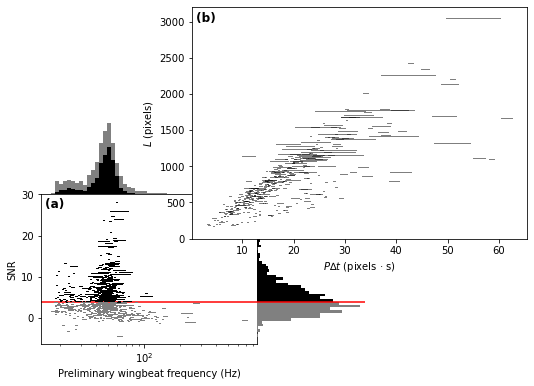

In [8]:
plotter = MatplotlibWingbeatFrequencyPlotter(
    polyline_regions=polyline_regions,
    snr_thresh=snr_thresh,
)
fig = plotter.plot()

## With zero bodylength assumption

Based on the above plots, we now wish to select a number of target classes. This will be used for fitting a Gaussian mixture-model to the preliminary winbeat frequencies (which assume zero bodylength), and for classification in the linear regression step for the unbiased estimate of wingbeat frequency.

In [9]:
n_classes = 2

Operating on the preliminary wingbeat data (figure a), we can fit a Gaussian mixture-model.

In [10]:
gmm = GMM.log10_from_region_dataframe(
    above_thresh,
    n_classes,
    seed=1234567890  # Not reuired to set, but makes the results
                     # reproducible
)
gmm_results = sorted(gmm.fit())  # Order of classes is random, so we sort
                                 # to make it predictable.

print("log10 Gaussian Mixture Model parameters:")
print("\n".join(str(r) for r in gmm_results))

log10 Gaussian Mixture Model parameters:
mean=1.3968704095248994 std=0.0755076055338635 weight=0.14025772662404282
mean=1.6913164856912772 std=0.07106824294152196 weight=0.8597422733759577


To get mean and standard deviation in Hz, we need to re-parametrise.

In [11]:
for weighted_gaussian in gmm_results:
    mean_hz, std_hz = weighted_gaussian.get_natural_params_from_log(10.0)
    print(f"μ = {mean_hz} Hz  σ = {std_hz}  weight = {weighted_gaussian.weight}")

μ = 25.102738892471677 Hz  σ = 2.8856693084544567  weight = 0.14025772662404282
μ = 49.41306955900124 Hz  σ = 5.34427937939624  weight = 0.8597422733759577


The estimate of standard deviation includes the measurement error associated with exposure time ambiguity. Here we will attempt to make an estimate of the underlying wingbeat frequency standard deviation.

First, we need to check that measurement error is not correlated with log10(wingbeat frequency)

In [12]:
log10_means = (np.log10(above_thresh.wb_freq_down) + np.log10(above_thresh.wb_freq_up)) / 2
log10_errors = log10_means - np.log10(above_thresh.wb_freq_down)

densities = np.stack([stats.norm.pdf(log10_means, loc=r.mean, scale=r.std) for r in gmm_results])
gmm_classification_prediction = densities.argmax(axis=0)

class 0:  r = 0.1120666137470634  p(|R| >= |r|) = 0.3042812058830173
class 1:  r = 0.10711341709033767  p(|R| >= |r|) = 0.017240476736024066


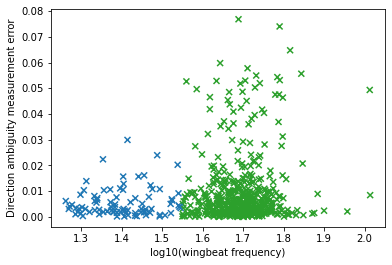

In [13]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="log10(wingbeat frequency)",
    ylabel="Direction ambiguity measurement error",
)
ax.scatter(
    log10_means,
    log10_errors,
    marker="x",
    c=np.array(["tab:blue", "tab:green"])[gmm_classification_prediction],
)

for i in range(n_classes):
    class_mask = gmm_classification_prediction == i
    r, p = stats.pearsonr(log10_means[class_mask], log10_errors[class_mask])
    print(f"class {i}:  r = {r}  p(|R| >= |r|) = {p}")

It appears that measurement error is not correlated to measurement value, so we can proceed using the relation

$$ Var(X + Y) = Var(X) + Var(Y) $$

In [14]:
log10_wingbeat_gaussians = []

for i in range(n_classes):
    class_mask = gmm_classification_prediction == i
    error_var = np.var(log10_errors[class_mask], ddof=1)
    log10_wingbeat_var = gmm_results[i].std ** 2 - error_var
    log10_wingbeat_gaussians.append(
        WeightedGaussian(
            mean=gmm_results[i].mean,
            std=np.sqrt(log10_wingbeat_var),
            weight=gmm_results[i].weight,
        )
    )
    
for weighted_gaussian in log10_wingbeat_gaussians:
    mean_hz, std_hz = weighted_gaussian.get_natural_params_from_log(10.0)
    print(f"μ = {mean_hz} Hz  σ = {std_hz}  weight = {weighted_gaussian.weight}")

μ = 25.101781030581876 Hz  σ = 2.8771046444652533  weight = 0.14025772662404282
μ = 49.403384640368735 Hz  σ = 5.25188370862169  weight = 0.8597422733759577


We can set the `gmm_results` parameter to plot the figure with the Gaussian mixture model shown.

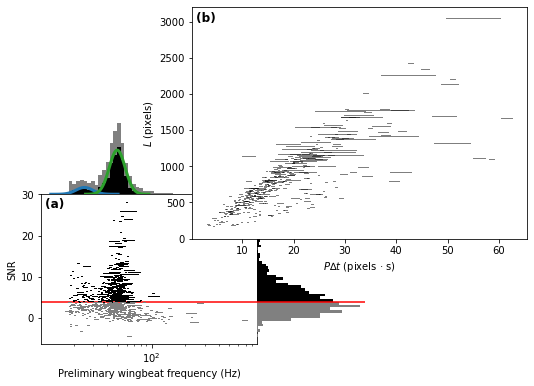

In [15]:
plotter = MatplotlibWingbeatFrequencyPlotter(
    polyline_regions=polyline_regions,
    snr_thresh=snr_thresh,
    gmm_results=gmm_results,
)
fig = plotter.plot()

## Without zero bodylength assumption

Now we use an EM algorithm to classify the data using BCES regressions of $L$ vs. $P \Delta t$.

In [16]:
bces_em = BcesEM.from_region_dataframe(
    above_thresh, n_classes, seed=1234567890
)
bces_results = bces_em.fit()

The order of the classes is random, so we sort to make them predictable (and line up better with the sorted classes from the GMM). This will make colouring comparable across the two models. Unfortunately we can't *just* sort `bces_results`, because then the colours of the scatter plot wouldn't be guaranteed to match the regression lines. We have to also re-map the `bces_em.class_mask` values.

This can do this re-mapping with some indexing trickery using `np.argsort`, and then we can sort `bces_results` the normal way.

In [17]:
inverse_index = np.argsort(np.argsort(bces_results))
class_mask = inverse_index[bces_em.class_mask]
class_n = np.bincount(class_mask)
bces_results = sorted(bces_results)

print("Classifications:")
print("\n".join(str(n) for n in class_n))
print("Multiple BCES linear regression parameters:")
print("\n".join(str(b) for b in bces_results))

Classifications:
75
505
Multiple BCES linear regression parameters:
gradient=23.684945219639722 y_intercept=21.164640791557133 gradient_stderr=1.8436575083709323 y_intercept_stderr=30.356672106881156 cov_xy=-54.37303718722761
gradient=48.648490469072115 y_intercept=30.410128999818426 gradient_stderr=1.4469572965456388 y_intercept_stderr=18.927271182452444 cov_xy=-26.431054889875146


### Testing zero bodylength assumption

We can test the zero body-length assumption by calculating the t-statistic of the intercept of the linear regression

$$ t = \frac{\hat{\beta_0} - 0}{SE(\hat{\beta_0})} $$

where $\hat{\beta_0}$ is the estimate of the intercept.
We then can test the following hypotheses:

$$ H_0 : \quad \hat{\beta_0} = 0 , $$
$$ H_1 : \quad \hat{\beta_0} > 0 . $$

We perform a one-sided test, since negative bodylength does not make physical sense (so there is no need for a two-sided test). Note that this is also more conservative, since a higher-powered test is more likely to reject $H_0$, which would force us to reject the zero body-length assumption.

In [18]:
t_values = np.array([estimates.y_intercept / estimates.y_intercept_stderr for estimates in bces_results])
dfs = class_n - 2  # Two estimators per linear regression
p_values = stats.t.sf(t_values, dfs)
print(t_values)
print(p_values)

[0.69719898 1.60668322]
[0.24394638 0.05437571]


We see that for both regressions, we have insufficient evidence to reject the zero body-length assumption ($p > 0.05$).
It is therefore reasonable to use the estimates given by the GMM approach.

In [19]:
for weighted_gaussian in log10_wingbeat_gaussians:
    mean_hz, std_hz = weighted_gaussian.get_natural_params_from_log(10.0)
    print(f"μ = {mean_hz} Hz  σ = {std_hz}  weight = {weighted_gaussian.weight}")

μ = 25.101781030581876 Hz  σ = 2.8771046444652533  weight = 0.14025772662404282
μ = 49.403384640368735 Hz  σ = 5.25188370862169  weight = 0.8597422733759577


Finally, we reproduce the figure from the publication, which includes both the GMM and EM classification

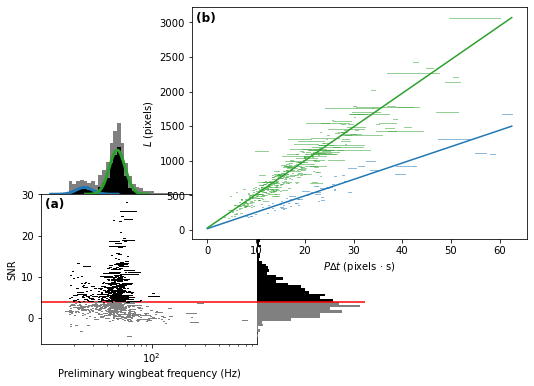

In [20]:
plotter = MatplotlibWingbeatFrequencyPlotter(
    polyline_regions=polyline_regions,
    snr_thresh=snr_thresh,          # Must be the same threshold used to
                                    # make the class_mask.
    class_mask=class_mask,          # Adds colour to the measurements
    gmm_results=gmm_results,        # Include the GMM plots
    bces_results=bces_results,      # Include the BCES regression lines
)
fig = plotter.plot()

`fig` is just a matplotlib `Figure` instance, so we can save it quite easily.

In [21]:
fig.savefig("wingbeat_frequency_figure.pdf", dpi=600.0, pad_inches=0.0)